# Lab 03: Generative Adversarial Networks
<b>Student's name: Hoang Le Cat Thanh 


Student's ID: 21127730</b>

## Import libraries

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

Device:  cpu


In [ ]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap='gray')
    return

In [ ]:
# Preprocess an image tensor
def preprocess_img(x):
    return 2 * x - 1.0

# Deprocess an image tensor
def deprocess_img(x):
    return (x + 1.0) / 2.0

# Calculate the relative error between two arrays
def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Count the total number of parameters in a model
def count_params(model):
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing data

In [ ]:
# Creating custom data samplers for PyTorch DataLoader
class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

# Dimensionality of the noise vector
NOISE_DIM = 128

# Batch size used for training
batch_size = 128

location_path = '/content/drive/MyDrive/Colab/MNIST'
mnist_train = torchvision.datasets.MNIST(root= location_path,
                                     train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = torchvision.datasets.MNIST(root= location_path,
                                     train=True, download=True, transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


## Defining the architecture

In [ ]:
def sample_noise(batch_size, dim):
    #Generate a PyTorch Tensor of uniform random noise.
    return torch.rand(batch_size, dim) * 2 - 1

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# Module for reshaping a flattened tensor into a 4D tensor
class Unflatten(nn.Module):
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

# Initializing weights of linear and transpose convolution layers
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [ ]:

def discriminator():
    # Build and return a PyTorch discriminator model
    model = nn.Sequential(
        # Flatten the input image tensor
        Flatten(),
        # Fully connected layer with 784 input features and 256 output features
        nn.Linear(784, 256),
        # Leaky ReLU activation function with negative slope of 0.01
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # Fully connected layer with 256 input features and 256 output features
        nn.Linear(256, 256),
        # Leaky ReLU activation function with negative slope of 0.01
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # Fully connected layer with 256 input features and 1 output feature
        nn.Linear(256, 1),
    )
    return model

In [ ]:
def generator(noise_dim=NOISE_DIM):
    # Build and return a PyTorch generator model
    model = nn.Sequential(
        # Fully connected layer with noise_dim input features and 1024 output features
        nn.Linear(noise_dim, 1024),
        # ReLU activation function
        nn.ReLU(inplace=True),
        # Fully connected layer with 1024 input features and 1024 output features
        nn.Linear(1024, 1024),
        # ReLU activation function
        nn.ReLU(inplace=True),
        # Fully connected layer with 1024 input features and 784 output features
        nn.Linear(1024, 784),
        # Tanh activation function to map outputs to the range [-1, 1]
        nn.Tanh(),
    )
    return model

In [ ]:
def bce_loss(input, target):
    #Numerically stable version of the binary cross-entropy loss function.
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [ ]:
def discriminator_loss(logits_real, logits_fake):
    #Computes the discriminator loss
    true_labels = Variable(torch.ones(logits_real.size())).type(dtype)

    # classifies fake images.
    real_image_loss = bce_loss(logits_real, true_labels)
    fake_image_loss = bce_loss(logits_fake, 1 - true_labels)

    loss = real_image_loss + fake_image_loss
    return loss

def generator_loss(logits_fake):
    #Computes the generator loss
    true_labels = Variable(torch.ones(logits_fake.size())).type(dtype)

    # Compute the generator loss compraing
    loss = bce_loss(logits_fake, true_labels)
    return loss

In [ ]:
def get_optimizer(model):
    #Construct and return an Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
    return optimizer

## Function for implementation

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250,
              batch_size=128, noise_size=128, num_epochs=50):
    iter_count = 0
    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch+1}")
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(), g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                fig = show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

## Run inference

Current epoch: 1
Iter: 0, D: 1.328, G:0.7254


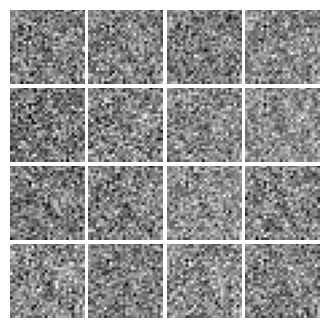


Iter: 250, D: 1.352, G:0.7311


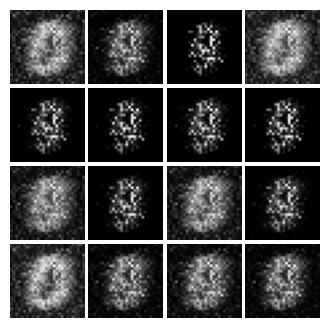


Current epoch: 2
Iter: 500, D: 1.004, G:1.162


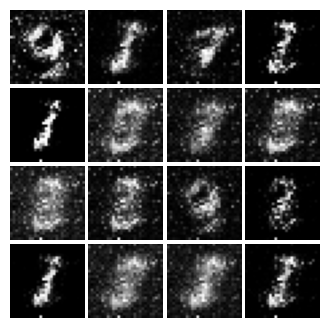


Iter: 750, D: 1.436, G:0.5291


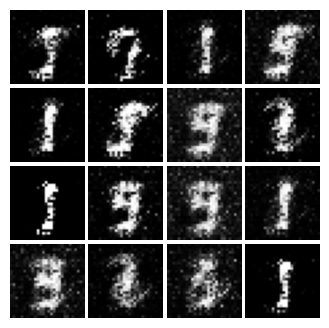


Current epoch: 3
Iter: 1000, D: 1.461, G:0.6943


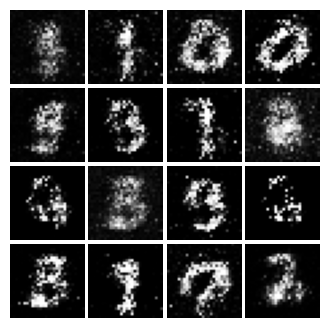


Current epoch: 4
Iter: 1250, D: 1.209, G:1.129


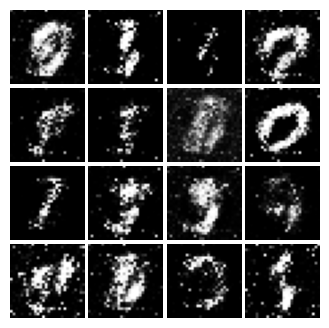


Iter: 1500, D: 1.334, G:0.8116


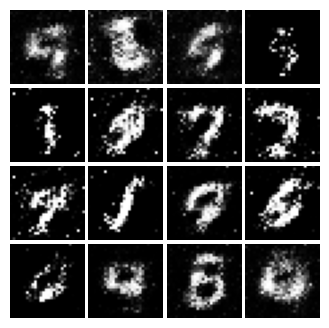


Current epoch: 5
Iter: 1750, D: 1.168, G:0.9089


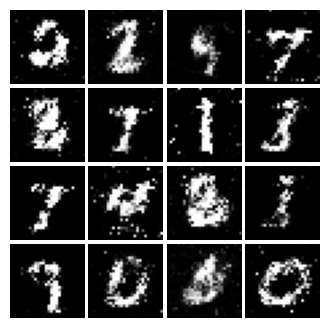


Current epoch: 6
Iter: 2000, D: 1.296, G:0.911


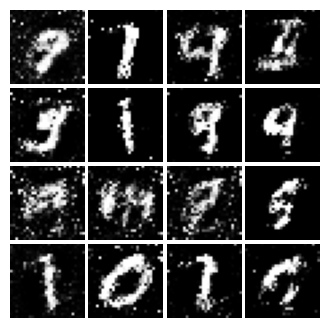


Iter: 2250, D: 1.253, G:0.7109


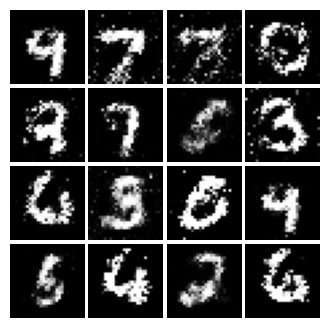


Current epoch: 7
Iter: 2500, D: 1.305, G:0.868


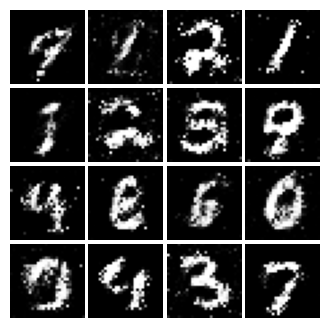


Current epoch: 8
Iter: 2750, D: 1.33, G:0.8174


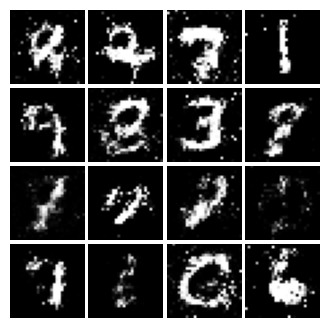


Iter: 3000, D: 1.326, G:0.7894


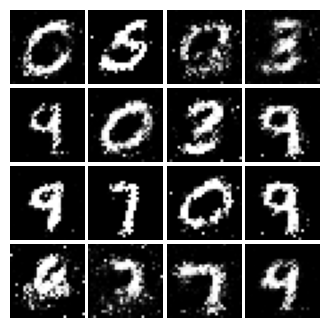


Current epoch: 9
Iter: 3250, D: 1.26, G:0.7747


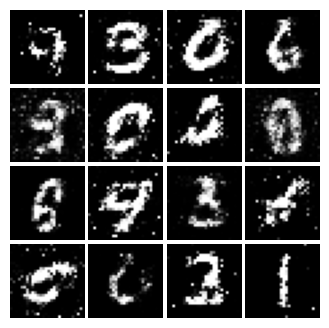


Iter: 3500, D: 1.365, G:0.8076


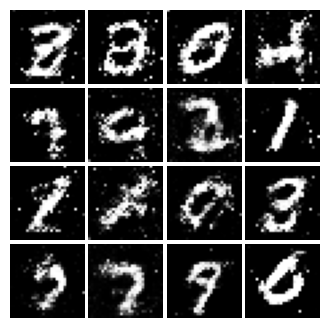


Current epoch: 10
Iter: 3750, D: 1.371, G:0.8742


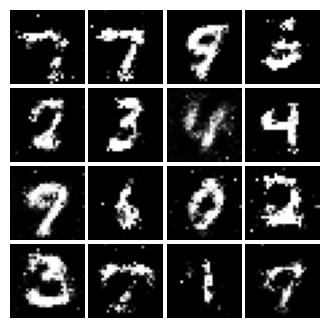


Current epoch: 11
Iter: 4000, D: 1.347, G:0.7138


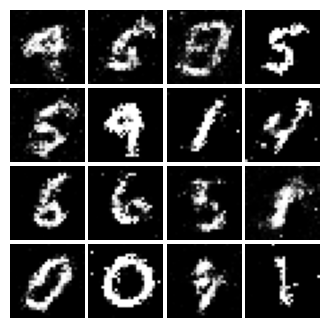


Iter: 4250, D: 1.326, G:0.7867


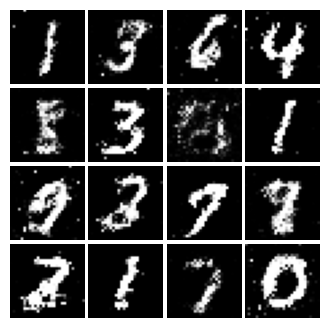


Current epoch: 12
Iter: 4500, D: 1.363, G:0.7723


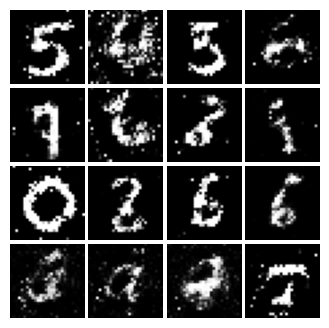


Current epoch: 13
Iter: 4750, D: 1.458, G:0.7474


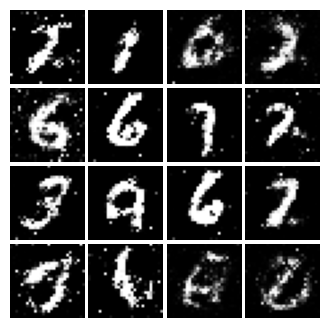


Iter: 5000, D: 1.373, G:0.7466


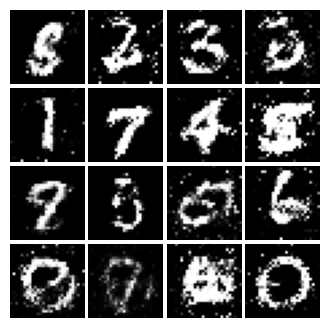


Current epoch: 14
Iter: 5250, D: 1.327, G:0.7647


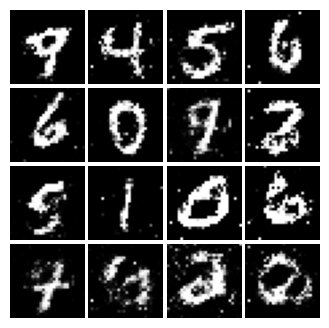


Current epoch: 15
Iter: 5500, D: 1.365, G:0.7464


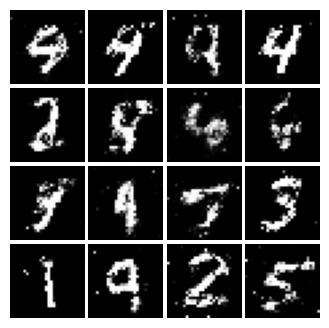


Iter: 5750, D: 1.307, G:0.8018


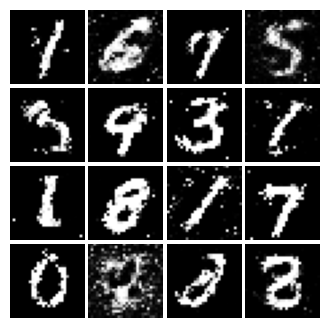


Current epoch: 16
Iter: 6000, D: 1.348, G:0.7897


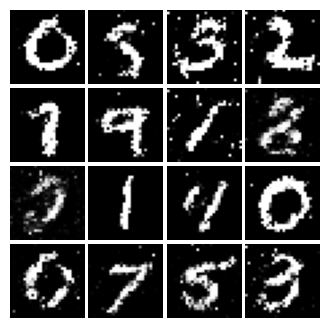


Current epoch: 17
Iter: 6250, D: 1.387, G:0.8834


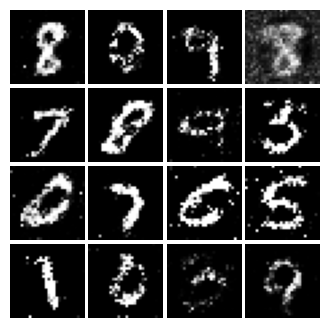


Iter: 6500, D: 1.359, G:0.7627


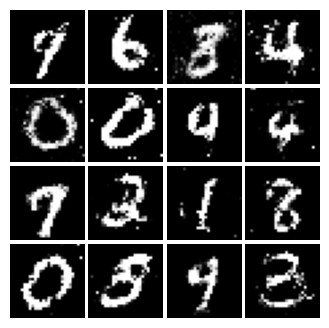


Current epoch: 18
Iter: 6750, D: 1.296, G:0.926


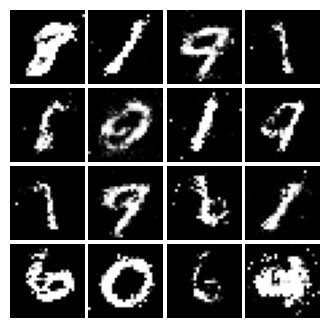


Iter: 7000, D: 1.343, G:0.742


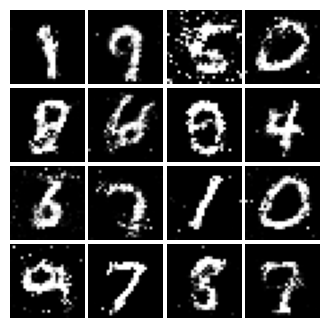


Current epoch: 19
Iter: 7250, D: 1.353, G:0.7554


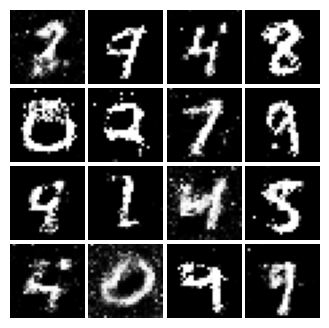


Current epoch: 20
Iter: 7500, D: 1.364, G:0.7483


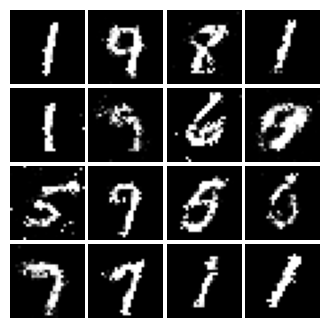


Iter: 7750, D: 1.306, G:0.7732


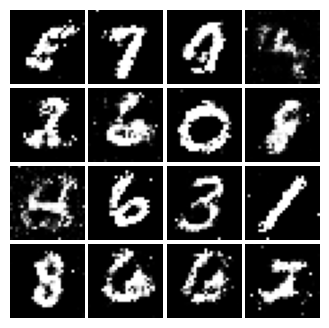


Current epoch: 21
Iter: 8000, D: 1.337, G:0.7458


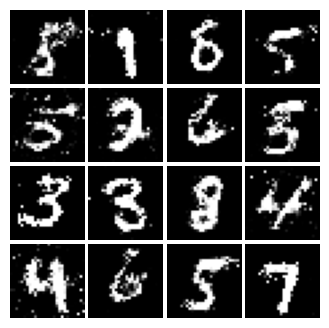


Current epoch: 22
Iter: 8250, D: 1.402, G:0.8033


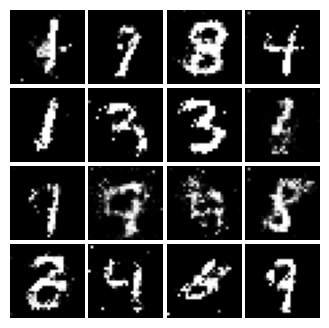


Iter: 8500, D: 1.375, G:0.7104


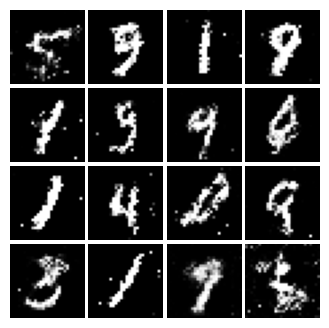


Current epoch: 23
Iter: 8750, D: 1.515, G:0.7664


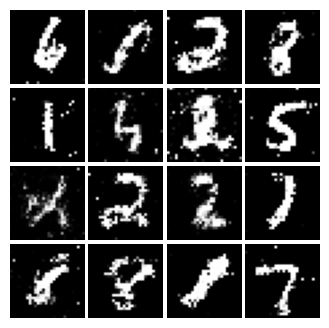


Current epoch: 24
Iter: 9000, D: 1.295, G:0.8121


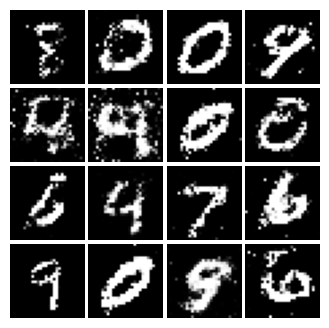


Iter: 9250, D: 1.412, G:0.7789


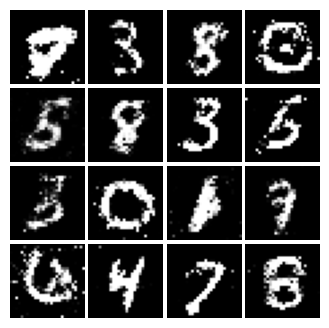


Current epoch: 25
Iter: 9500, D: 1.389, G:0.8367


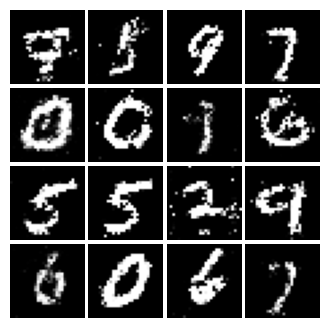


Current epoch: 26
Iter: 9750, D: 1.37, G:0.8458


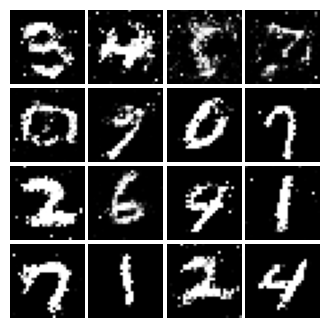


Iter: 10000, D: 1.452, G:0.7953


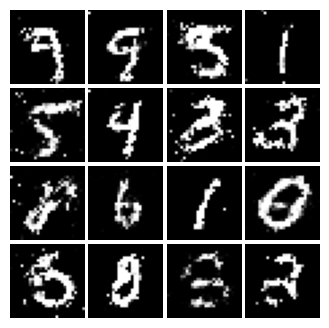


Current epoch: 27
Iter: 10250, D: 1.292, G:0.9087


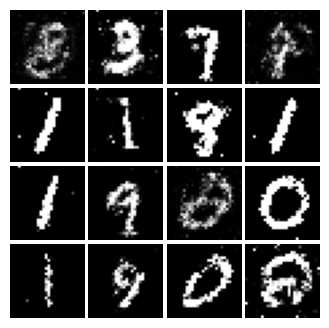


Iter: 10500, D: 1.324, G:0.8106


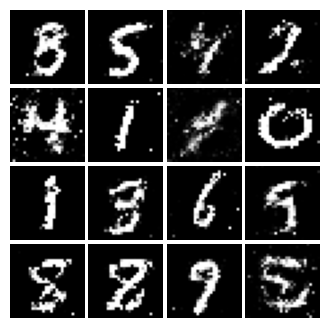


Current epoch: 28
Iter: 10750, D: 1.285, G:0.8725


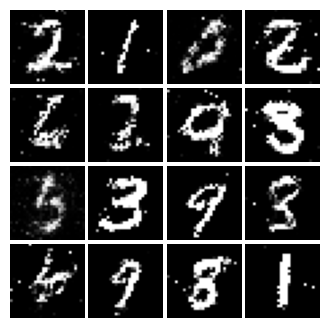


Current epoch: 29
Iter: 11000, D: 1.306, G:0.8048


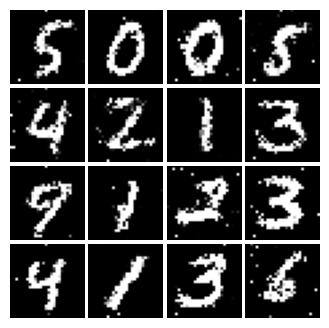


Iter: 11250, D: 1.247, G:0.8698


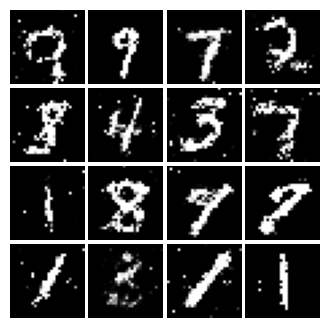


Current epoch: 30
Iter: 11500, D: 1.285, G:0.8633


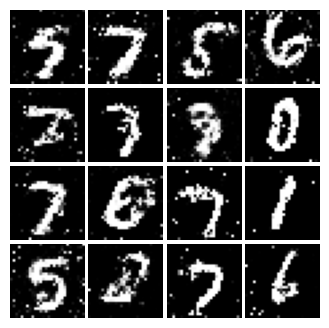


Current epoch: 31
Iter: 11750, D: 1.304, G:0.8725


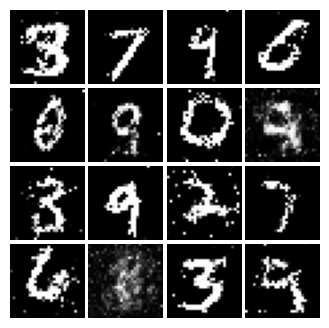


Iter: 12000, D: 1.251, G:0.863


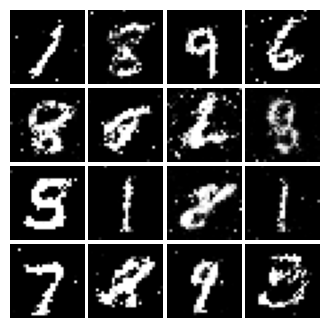


Current epoch: 32
Iter: 12250, D: 1.301, G:0.779


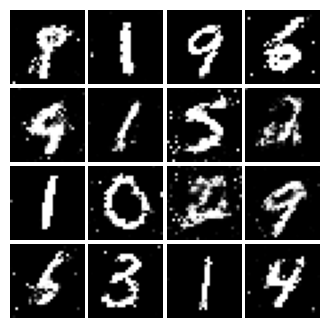


Current epoch: 33
Iter: 12500, D: 1.312, G:0.8201


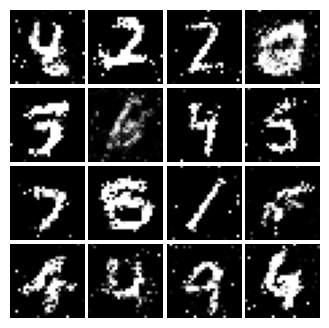


Iter: 12750, D: 1.252, G:0.8127


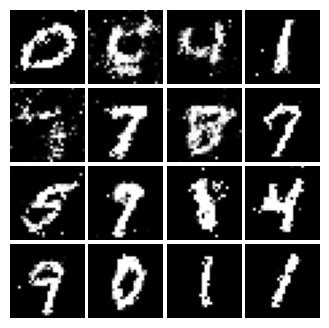


Current epoch: 34
Iter: 13000, D: 1.233, G:0.876


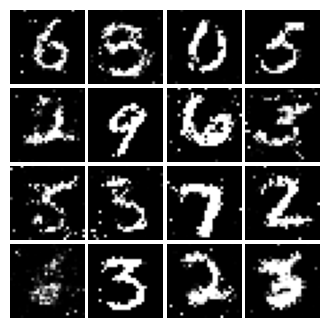


Iter: 13250, D: 1.236, G:0.9234


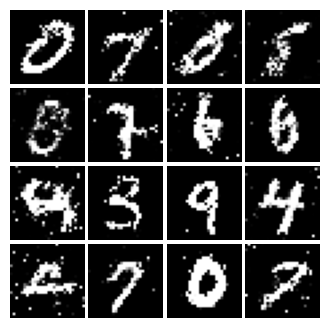


Current epoch: 35
Iter: 13500, D: 1.256, G:0.8572


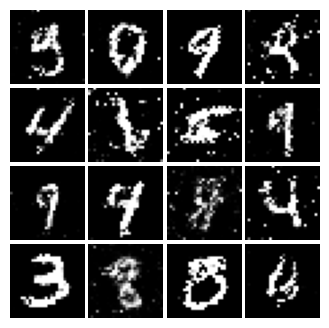


Current epoch: 36
Iter: 13750, D: 1.214, G:0.9661


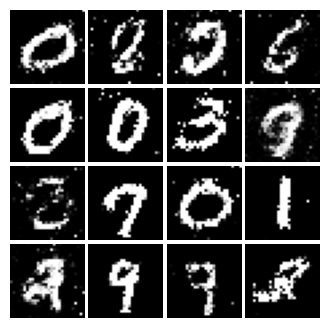


Iter: 14000, D: 1.212, G:1.034


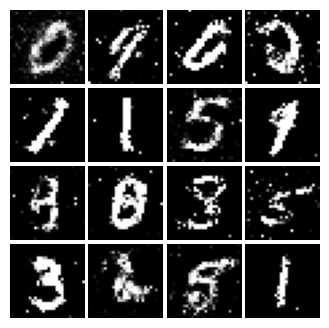


Current epoch: 37
Iter: 14250, D: 1.282, G:0.6844


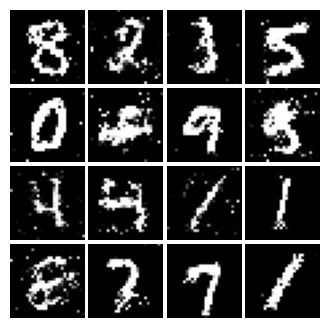


Current epoch: 38
Iter: 14500, D: 1.244, G:0.8175


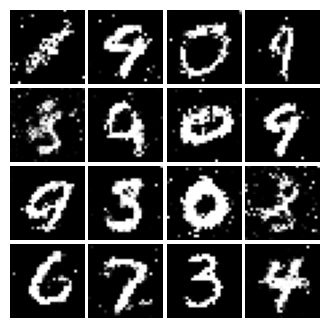


Iter: 14750, D: 1.209, G:1.16


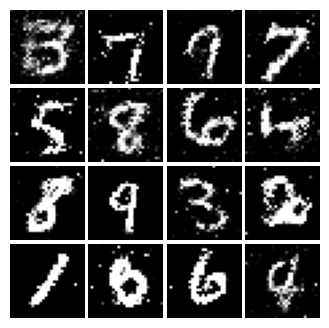


Current epoch: 39
Iter: 15000, D: 1.071, G:1.078


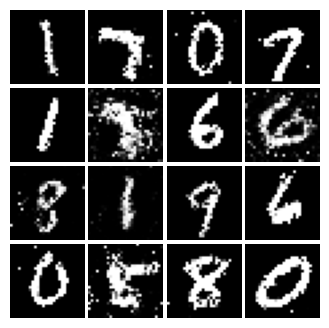


Current epoch: 40
Iter: 15250, D: 1.167, G:1.03


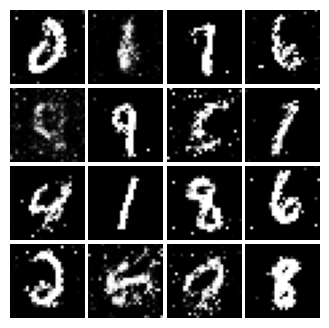


Iter: 15500, D: 1.141, G:1.167


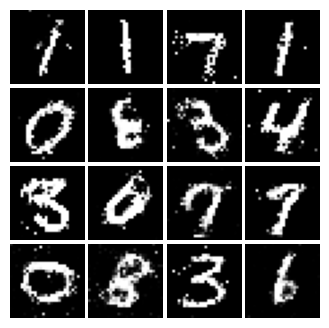


Current epoch: 41
Iter: 15750, D: 1.251, G:0.9362


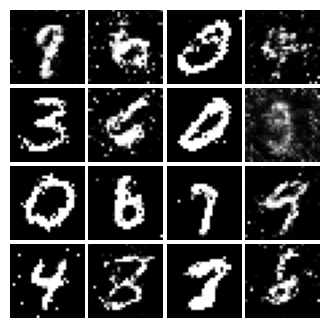


Current epoch: 42
Iter: 16000, D: 1.109, G:1.056


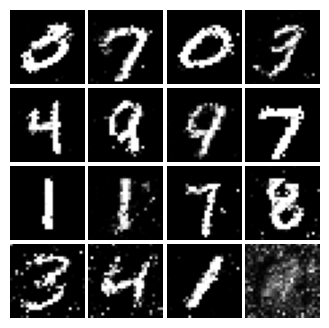


Iter: 16250, D: 1.054, G:1.263


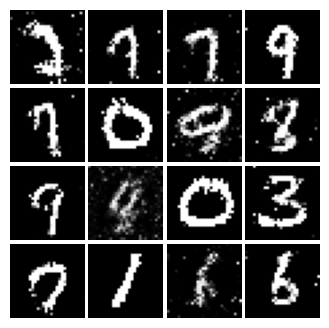


Current epoch: 43
Iter: 16500, D: 0.994, G:1.241


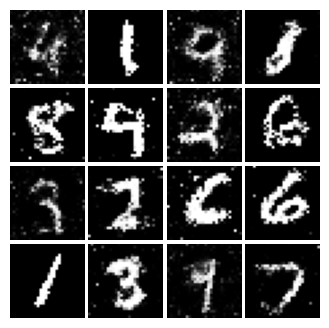


Iter: 16750, D: 1.24, G:1.11


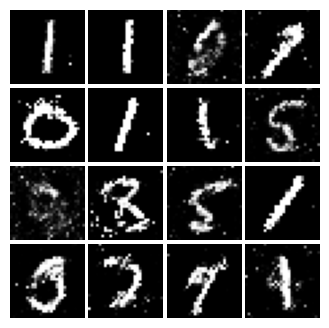


Current epoch: 44
Iter: 17000, D: 1.128, G:1.138


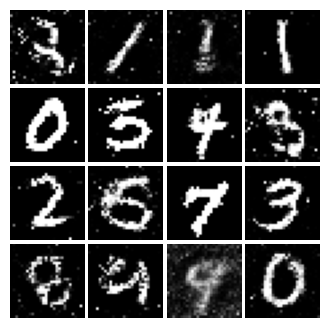


Current epoch: 45
Iter: 17250, D: 1.133, G:1.207


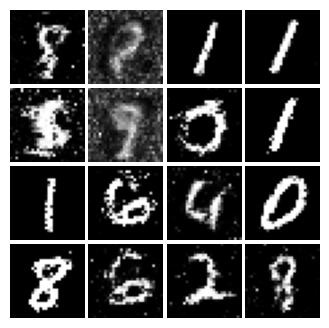


Iter: 17500, D: 1.108, G:1.28


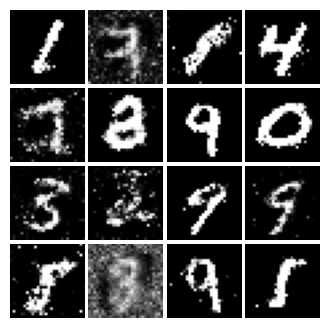


Current epoch: 46
Iter: 17750, D: 1.015, G:1.508


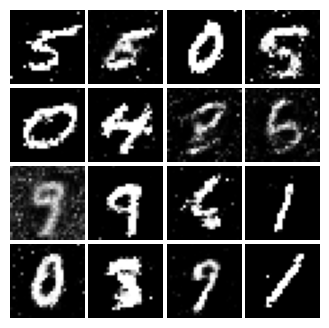


Current epoch: 47
Iter: 18000, D: 1.08, G:1.179


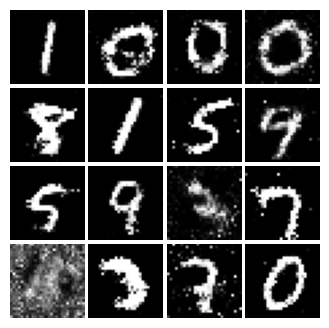


Iter: 18250, D: 1.08, G:1.288


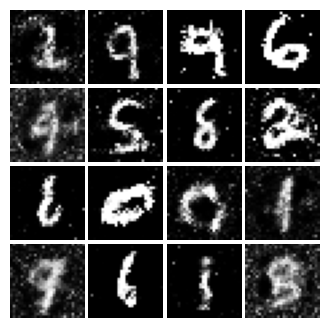


Current epoch: 48
Iter: 18500, D: 1.133, G:1.271


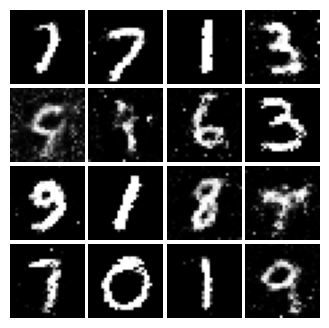


Current epoch: 49
Iter: 18750, D: 0.9861, G:1.28


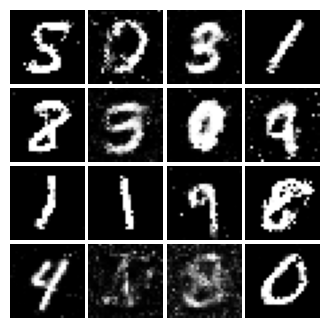


Iter: 19000, D: 0.9999, G:1.213


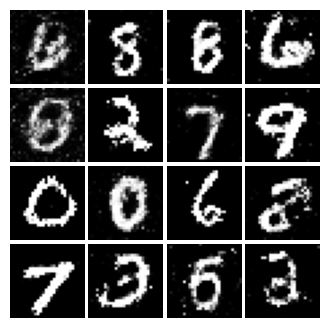


Current epoch: 50
Iter: 19250, D: 1.104, G:1.273


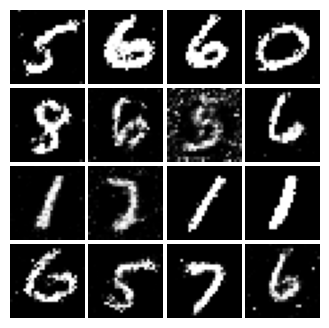

In [ ]:
dtype = torch.FloatTensor

# Instantiate the discriminator and generator models
D = discriminator().type(dtype)
G = generator().type(dtype)

# Initialize optimizers for the discriminator and generator models
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run the GAN training procedure with the specified discriminator, generator, optimizers, and loss functions
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)